In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
import seaborn as sns

sys.path.append(r"D:\github\ripple_heterogeneity\python")
import functions, loading, assembly_run

sys.path.append(r"D:\github\neurocode\reactivation\assemblies")
import assembly
import assembly_activation
import assembly_individual_epochs

import nelpy as nel
import nelpy.plotting as npl

import itertools
import os

import pickle
from scipy import stats
import glob
from scipy.stats import chisquare

from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib

import random
from tqdm import tqdm


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [3]:
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

functions.set_plotting_defaults()

## Make pre/task/post assembly activation strength for novel sessions

In [ ]:
save_path_assembly = r'Z:\home\ryanh\projects\ripple_heterogeneity\cell_assembly'
sessions = glob.glob(save_path_assembly +os.sep+ '*.pkl')
sessions = [string for string in sessions if 'GrosmarkAD' in string]

basepath = []
for session in sessions:
    with open(session, 'rb') as f:
        results = pickle.load(f)
    basepath.append(results['basepath'])

temp_df = pd.DataFrame()
temp_df['basepath'] = basepath    

save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\assembly_activation'

assembly_activation.assembly_run_activation(temp_df,save_path,save_path_assembly,parallel=False)

## discover assemblies on each epoch

In [4]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")
df = df[df.basepath.str.contains("GrosmarkAD")]
df2 = pd.DataFrame()
#    'Z:\\Data\\AYAold\\AYA4\\day150804',
#    'Z:\\Data\\AYAold\\AYA7\\day19',
df2["basepath"] = ["Z:\Data\HMC1\day8", "Z:\\Data\\Kenji\\ec014.459_480"]
df = pd.concat([df, df2], ignore_index=True)
df
# save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\cell_assembly_epochs_5ms'
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\cell_assembly_epochs_10ms"
# save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\cell_assembly_epochs_40ms'

assembly_individual_epochs.assembly_run(df, save_path, parallel=True)


## Load results and re-classify deep / sup

In [5]:
df = assembly_individual_epochs.load_assem_epoch_data(save_path)

LAYERDIST = 30
deep = -LAYERDIST
middle = [-LAYERDIST, LAYERDIST]
sup = LAYERDIST
df.loc[df.deepSuperficialDistance <= deep, "deepSuperficial"] = "Deep"
df.loc[(df.deepSuperficialDistance > middle[0]) & (df.deepSuperficialDistance < middle[1]),"deepSuperficial",] = "middle"
df.loc[df.deepSuperficialDistance >= sup, "deepSuperficial"] = "Superficial"

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


### assembly weights over pre/task/post

In [6]:
df.loc[df.epoch_n == 0,"epoch_name"] = "Pre-sleep"
df.loc[df.epoch_n == 1,"epoch_name"] = "Task"
df.loc[df.epoch_n == 2,"epoch_name"] = "Post-sleep"

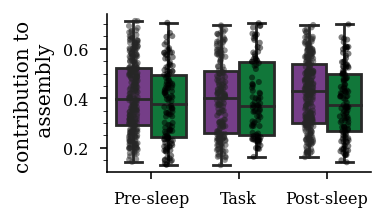

In [143]:
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

df['weights_abs'] = df.weights.abs()

w, h = functions.set_size("thesis", fraction=0.4, subplots=(1.5, 1))
fig, ax = plt.subplots(figsize=(w, h / 1.5), edgecolor=None)
sns.boxplot(
    x="epoch_name",
    y="weights_abs",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=df[df.membership],
)

sns.stripplot(
    x="epoch_name",
    y="weights_abs",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=df[df.membership],
    dodge=True,
    color="k",
    alpha=0.5,
    s=3
)

ax = plt.gca()
ax.set_ylabel('contribution to \n assembly')
ax.set_xlabel('')

# axs.legend(
#     loc="best", bbox_to_anchor=(1, -0.2, 0.5, 1.2), fontsize="x-small", frameon=False
# )

ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.get_legend().remove()

plt.savefig(os.path.join(fig_save_path,'contribution_to_assembly_pre_task_post.svg'),dpi=300,bbox_inches='tight')


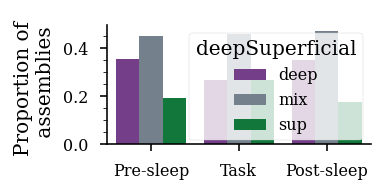

In [146]:
def get_assembly_composition(df):
    mixed = 0
    deep_biased = 0
    sup_biased = 0

    for n_as in df.assembly_n.unique():
        current_df = df[df.assembly_n == n_as]
        mem_idx = current_df.membership == True
        sup_idx = current_df.deepSuperficial == "Superficial"
        deep_idx = current_df.deepSuperficial == "Deep"

        if ((deep_idx & mem_idx).sum() > 0) & ((sup_idx & mem_idx).sum() > 0):
            mixed += 1
        elif ((deep_idx & mem_idx).sum() > 1) & ((sup_idx & mem_idx).sum() == 0):
            deep_biased += 1
        elif ((deep_idx & mem_idx).sum() == 0) & ((sup_idx & mem_idx).sum() > 0):
            sup_biased += 1
    return mixed, deep_biased, sup_biased


mixed_ps, deep_biased_ps, sup_biased_ps = get_assembly_composition(
    df[df.epoch_name == "Pre-sleep"]
)
mixed_t, deep_biased_t, sup_biased_t = get_assembly_composition(
    df[df.epoch_name == "Task"]
)
mixed_po, deep_biased_po, sup_biased_po = get_assembly_composition(
    df[df.epoch_name == "Post-sleep"]
)


df_comp = pd.DataFrame()
df_comp["composition"] = np.array(
    [
        mixed_ps,
        deep_biased_ps,
        sup_biased_ps,
        mixed_t,
        deep_biased_t,
        sup_biased_t,
        mixed_po,
        deep_biased_po,
        sup_biased_po,
    ]
)

df_comp["deepSuperficial"] = [
    "mix",
    "deep",
    "sup",
    "mix",
    "deep",
    "sup",
    "mix",
    "deep",
    "sup",
]
df_comp["epoch"] = [
    "Pre-sleep",
    "Pre-sleep",
    "Pre-sleep",
    "Task",
    "Task",
    "Task",
    "Post-sleep",
    "Post-sleep",
    "Post-sleep",
]

for epoch in df_comp.epoch.unique():
    df_comp.loc[df_comp.epoch == epoch, "composition_prop"] = (
        df_comp[df_comp.epoch == epoch].composition
        / df_comp[df_comp.epoch == epoch].composition.sum()
    )

w, h = functions.set_size("thesis", fraction=0.4, subplots=(1.5, 1))

fig, ax = plt.subplots(figsize=(w, h / 2), edgecolor=None)

group_colors = {"deep": "#7b3294", "mix": "slategrey", "sup": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

g = sns.barplot(
    data=df_comp,
    x="epoch",
    y="composition_prop",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    ax=ax,
)

ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.set_ylabel("Proportion of \n assemblies")

ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
# ax.get_legend().remove()
ax.set_xlabel("")

plt.savefig(
    os.path.join(fig_save_path, "compsition_of_assembly_pre_task_post.svg"),
    dpi=300,
    bbox_inches="tight",
)


In [7]:
import assembly_corrs_deep_sup

save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\assembly_unit_corrs_deep_sup_pre'
assembly_corrs_deep_sup.assembly_corr_run(df,save_path,parallel=True,epoch="pre")

save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\assembly_unit_corrs_deep_sup_task'
assembly_corrs_deep_sup.assembly_corr_run(df,save_path,parallel=True,epoch="task")

save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\assembly_unit_corrs_deep_sup_post'
assembly_corrs_deep_sup.assembly_corr_run(df,save_path,parallel=True,epoch="post")


In [8]:
save_paths = [r'Z:\home\ryanh\projects\ripple_heterogeneity\assembly_unit_corrs_deep_sup_pre',
             r'Z:\home\ryanh\projects\ripple_heterogeneity\assembly_unit_corrs_deep_sup_task',
             r'Z:\home\ryanh\projects\ripple_heterogeneity\assembly_unit_corrs_deep_sup_post']

corr_df = pd.DataFrame()
for i,save_path in enumerate(save_paths):
    sessions = glob.glob(save_path +os.sep+ '*.csv')
    for session in sessions:
        temp_df = pd.read_csv(session)
        temp_df['epoch'] = i
        corr_df = pd.concat([corr_df,temp_df],ignore_index=True)
corr_df

,Unnamed: 0,rho,label,assembly_id,basepath,epoch
0,0,-0.003529,deep,0.0,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013,0
1,1,-0.003555,deep,0.0,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013,0
2,2,0.013585,deep,0.0,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013,0
3,3,-0.029582,deep,0.0,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013,0
4,4,-0.003747,deep,0.0,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013,0
...,...,...,...,...,...,...
17575960,161335,0.037818,non_member_deep,453.0,Z:\Data\Kenji\ec014.459_480,2
17575961,161336,0.037095,non_member_deep,453.0,Z:\Data\Kenji\ec014.459_480,2
17575962,161337,0.127085,non_member_deep,453.0,Z:\Data\Kenji\ec014.459_480,2
17575963,161338,0.030874,non_member_deep,453.0,Z:\Data\Kenji\ec014.459_480,2


In [9]:
corr_df['label_2'] = 'unknown'
idx = (corr_df.label == 'member_deep') | (corr_df.label == 'member_sup')
corr_df.loc[idx,'label_2'] = 'member_same_layer'

idx = (corr_df.label == 'member_deep_sup')
corr_df.loc[idx,'label_2'] = 'member_cross_layer'

idx = (corr_df.label == 'non_member_deep') | (corr_df.label == 'non_member_sup') | (corr_df.label == 'non_member_deep_sup') 
corr_df.loc[idx,'label_2'] = 'non_member'

In [50]:
corr_df.loc[corr_df.epoch == 0,"epoch_name"] = "Pre-sleep"
corr_df.loc[corr_df.epoch == 1,"epoch_name"] = "Task"
corr_df.loc[corr_df.epoch == 2,"epoch_name"] = "Post-sleep"

In [45]:
# get mean rho for each assembly_id in corr_df
# test_df = corr_df.groupby(by=['label_2','assembly_id','epoch'])['rho'].mean()
# test_df = test_df.reset_index()


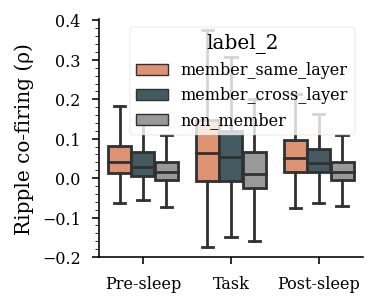

In [59]:
w, h = functions.set_size("thesis", fraction=0.4, subplots=(1.5, 1))

fig, ax = plt.subplots(figsize=(w, h), edgecolor=None)
axs = plt.gca()

group_colors = {"member_same_layer": '#ef8a62',
            'member_cross_layer': '#3e5d66',
            "non_member": '#999999'}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.boxplot(
    x="epoch_name",
    y="rho",
    hue="label_2",
    hue_order=group_colors.keys(),
    data=corr_df,
    fliersize=0.5,
    showfliers=False
)

right_side = axs.spines["right"]
right_side.set_visible(False)
top_side = axs.spines["top"]
top_side.set_visible(False)
axs.yaxis.set_minor_locator(AutoMinorLocator())

axs.set_ylabel('Ripple co-firing (ρ)')
axs.set_xlabel('')

plt.savefig(os.path.join(fig_save_path,'assembly_member_correlation_pre_task_post.svg'),dpi=300,bbox_inches='tight')


## plot assembly activation strength by overall participation prob. over ripples 

See if, during the novel environment exploration, the first assemblies that appear are the ones formed by high-participation cells as well

of sig members, find mean/median/range/std participation prob per assembly

for assembly strength over time, locate any peak $R >= 5$.

In [110]:
patterns_keep,is_member_keep,keep_assembly,is_member = functions.find_sig_assemblies(results['patterns'][0])
patterns_keep.shape

(11, 60)

## Testing out different dt

In [ ]:
def load_assem_epoch_data(save_path):

    sessions = glob.glob(save_path +os.sep+ '*.pkl')

    assem_epoch_df = pd.DataFrame()

    for session in sessions:
        assem_epoch_df_temp = pd.DataFrame()
        prob_sig_member = []
        n_members = []
        n_assemblies = []
        n_cells = []
        epoch = []
        with open(session, 'rb') as f:
            results = pickle.load(f)

            for i,pattern_ep in enumerate(results['patterns']):
                patterns_keep,is_member_keep,keep_assembly,is_member = functions.find_sig_assemblies(pattern_ep)
                prob_sig_member.append(np.mean(is_member_keep))
                n_members.append(is_member_keep.sum())
                n_assemblies.append(patterns_keep.shape[0])
                n_cells.append(patterns_keep.shape[1])
                epoch.append(str(i))
                
            assem_epoch_df_temp['prob_sig_member'] = prob_sig_member
            assem_epoch_df_temp['n_members'] = n_members
            assem_epoch_df_temp['n_assemblies'] = n_assemblies
            assem_epoch_df_temp['n_cells'] = n_cells
            assem_epoch_df_temp['epoch'] = epoch
            assem_epoch_df_temp['basepath'] = results['basepath']
        
        assem_epoch_df = pd.concat([assem_epoch_df,assem_epoch_df_temp],ignore_index=True)

    return assem_epoch_df

assem_epoch_df = pd.DataFrame()

save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\cell_assembly_epochs_5ms'
assem_epoch_df_temp = load_assem_epoch_data(save_path)
assem_epoch_df_temp['binsize'] = '5ms'
assem_epoch_df = pd.concat([assem_epoch_df,assem_epoch_df_temp],ignore_index=True)

save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\cell_assembly_epochs_10ms'
assem_epoch_df_temp = load_assem_epoch_data(save_path)
assem_epoch_df_temp['binsize'] = '10ms'
assem_epoch_df = pd.concat([assem_epoch_df,assem_epoch_df_temp],ignore_index=True)

save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\cell_assembly_epochs_20ms'
assem_epoch_df_temp = load_assem_epoch_data(save_path)
assem_epoch_df_temp['binsize'] = '20ms'
assem_epoch_df = pd.concat([assem_epoch_df,assem_epoch_df_temp],ignore_index=True)

save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\cell_assembly_epochs_40ms'
assem_epoch_df_temp = load_assem_epoch_data(save_path)
assem_epoch_df_temp['binsize'] = '40ms'
assem_epoch_df = pd.concat([assem_epoch_df,assem_epoch_df_temp],ignore_index=True)


In [10]:
assem_epoch_df['normalized_nassemb'] = assem_epoch_df.n_assemblies / assem_epoch_df.n_cells

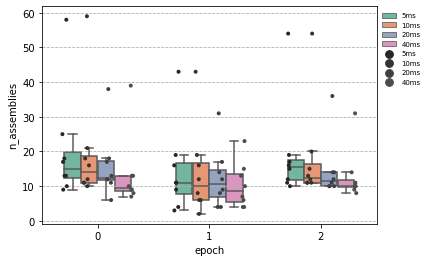

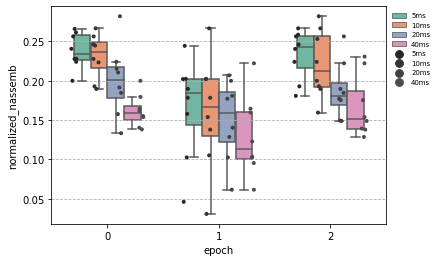

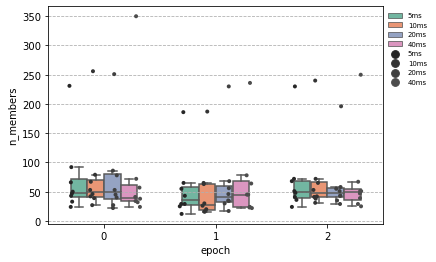

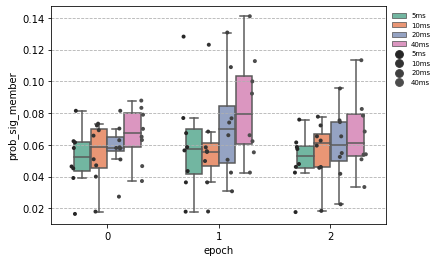

In [11]:
plt.figure()
plt.grid(linestyle='--',zorder=-100)
sns.boxplot(x="epoch", y="n_assemblies", hue='binsize', data=assem_epoch_df,
            width=.6, palette="Set2",showfliers=False)
sns.stripplot(x="epoch", y="n_assemblies",hue='binsize', data=assem_epoch_df,
              size=4, color=".3", linewidth=0, dodge=True)
axs=plt.gca()
axs.legend(loc='best', bbox_to_anchor=(.65, -0.2, 0.5, 1.2),
            fontsize='x-small',frameon=False)


plt.figure()
plt.grid(linestyle='--',zorder=-100)
sns.boxplot(x="epoch", y="normalized_nassemb", hue='binsize', data=assem_epoch_df,
            width=.6, palette="Set2",showfliers=False)
sns.stripplot(x="epoch", y="normalized_nassemb",hue='binsize', data=assem_epoch_df,
              size=4, color=".3", linewidth=0, dodge=True)
axs=plt.gca()
axs.legend(loc='best', bbox_to_anchor=(.65, -0.2, 0.5, 1.2),
            fontsize='x-small',frameon=False)

plt.figure()
plt.grid(linestyle='--',zorder=-100)
sns.boxplot(x="epoch", y="n_members", hue='binsize', data=assem_epoch_df,
            width=.6, palette="Set2",showfliers=False)
sns.stripplot(x="epoch", y="n_members",hue='binsize', data=assem_epoch_df,
              size=4, color=".3", linewidth=0, dodge=True)
axs=plt.gca()
axs.legend(loc='best', bbox_to_anchor=(.65, -0.2, 0.5, 1.2),
            fontsize='x-small',frameon=False)

plt.figure()
plt.grid(linestyle='--',zorder=-100)
sns.boxplot(x="epoch", y="prob_sig_member", hue='binsize', data=assem_epoch_df,
            width=.6, palette="Set2",showfliers=False)
sns.stripplot(x="epoch", y="prob_sig_member",hue='binsize', data=assem_epoch_df,
              size=4, color=".3", linewidth=0, dodge=True)
axs=plt.gca()
axs.legend(loc='best', bbox_to_anchor=(.65, -0.2, 0.5, 1.2),
            fontsize='x-small',frameon=False)